## Using programmable Flow Injection (pFI) for the Determination of Phosphate in Seawater ##
#### Marine Lebrec ###

#### *What is programmable Flow Injection?* ####

Programmable Flow Injection analysis builds upon previous generations of flow analysis techniques, whereby a target analyte is measured by transporting a sample and reagent solution through an instrument manifold by the use of peristaltic pumps, and quantified via a detector (Cerda et al., 2014). While traditional flow analysis technologies remain extremely useful in analytical chemistry, several limitations exist in these methodologies which are addressed through pFI. One of the key advantages of pFI relative to conventional Flow Injection Analysis (FIA) is the incorporation of a “confluence point”, connecting sample/reagent ports to two bidirectional pumps, allowing for highly efficient mixing using predetermined flow rates and volumes (Hatta et al., 2018). In addition, pFI instrumentation is miniaturized and does not require continuous flow, meaning that analysis can be performed using much smaller sample/reagent volumes, reducing the amount of hazardous waste produced.

The main components of the pFI instrument that I am using includes:
* Two bi-directional peristaltic pumps 
* Thermostatically regulated holding coils
* 6-port Lab-on-Valve equipped with a confluence point
* Tungsten light source attached to a 10cm flow cell and external spectrophotometer via optical fibers


<img src="../../pFI_pic.png" alt="Drawing" style="width: 700px;"/>


#### *How can pFI be used to measure phosphate in seawater?* ####

Phosphate determination can be done using methods originally described by Murphy & Riley (1962) in which a two step assay is used where acidified molybdate reacts with the phosphate in a sample to form phosphomolybdic acid. The phosphomolybdic acid complex is then reduced to phosphomolybdenum blue using ascorbic acid. The phosphomolybdenum blue is monitored via absorbance spectrophotometry, which is proportional to the amount of phosphate in a sample, based on the Beer-Lambert Law. Phosphate is typically monitored at a wavelength of 880nm. 

This method is applied to pFI by using the mixing sequence shown and described below:
1. Ascorbic Acid is aspirated into Holding Coil 1. 
2. Ascorbic Acid is dispensed while the Molybdate reagent is aspirated into Holding Coil 2 at a 1:1 ratio.
3. The sample is aspirated while the mixed Ascorbic Acid + Molybdate reagent is dispensed into Holding Coil 1.
4. The mixed sample + reagent assay is dispensed to the flow cell for detection after a 30 second wait period.

<img src="../../pFI_mixing.png" alt="Drawing" style="width: 300px;"/>

#### *pFI Data Storage and File Structure* ####

When a sample is run using pFI, the pFI software (FloZF) stores two tab-delimited files into a project's data folder:
1. The **absorbance spectrum** of the sample over the range of wavelengths used by the spetrophotometer. The first row corresponds to a unique index, or identifier for each sample that is run within a project. The second row lists the time that the data was recorded, and the remaining rows include the absorbance values at each wavelength.

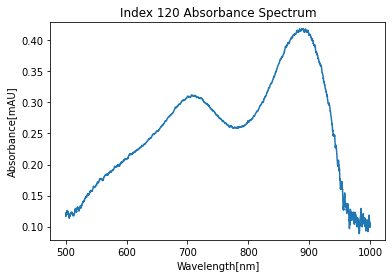

In [2]:
import pfi
pfi.plot_spectra(120)

2. A **time series** of the absorbance values over the period of sample analysis at wavelengths specified using FloZF. The first 31 lines in the file include recorded information about the absorbance values at specified times in a sequence using various reference wavelengths. The remainder of the file includes the time series of absorbance values using the specified reference wavelengths.

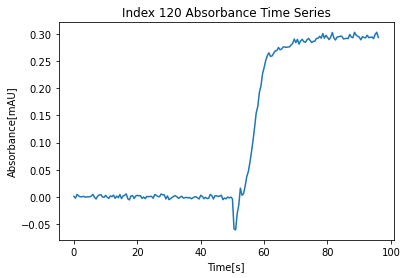

In [3]:
pfi.plot_timeseries(120,'A880-A510')

#### *Extracting information from pFI files to analyze data* ####

Oceanographers are often interested in running numerous samples, whether it be for method development, or using pFI as a benchtop of in-situ method. To look at any sample index spectra or time-series information, a Python dictionary can be used. 

In [4]:
#Extracting an absorbance value at 880nm-510nm for any index (note: could be made into a function)
import numpy as np
import pandas as pd

indexes = np.arange(1230,1235)  #need to make if statement here since not all indexes exist


absorbances = dict()
A880 = dict()

for i in indexes:
        absorbances[i] = pd.read_csv('master_data/sample_'+ str(i) + '.pfl', delimiter='\t', nrows=30)
        
        absorbances[i] = absorbances[i].replace(to_replace=absorbances[i]['sample name'][23], value='A880-A510', inplace=False, limit=None, regex=False, method='pad')
        absorbances[i] = absorbances[i].replace(to_replace=absorbances[i]['sample name'][16], value='A880-A775', inplace=False, limit=None, regex=False, method='pad')
        absorbances[i] = absorbances[i].replace(to_replace=absorbances[i]['sample name'][9], value='A880-A975', inplace=False, limit=None, regex=False, method='pad')

        Abs = absorbances[i]['sample name'] == "A880-A510"
        A880[i] = 'Absorbance[mAU] = ' + absorbances[i][Abs]['sample']
    

    
#Using the above dictionary to look up the absorbance value using a reference wavelength of A510 for any sample
A880[1231]

23    Absorbance[mAU] = 0.295848
Name: sample, dtype: object

Text(0.5, 1.0, 'Absorbance Spectras')

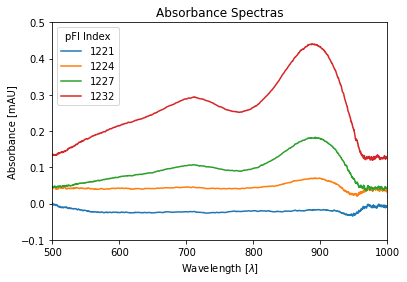

In [5]:
#Plotting spectras from any pFI indexes
import matplotlib.pyplot as plt

indexes = np.arange(1, 1263) 
spectras = dict()
for i in indexes:
    spectras[i] = pd.read_csv('master_data/sample_'+ str(i) + '.spectrum.pfl', delimiter='\t', skiprows=3)

plt.figure()
plt.plot(spectras[1221]['Wavelength (nm)'],spectras[1221]['Absorbance'])
plt.plot(spectras[1224]['Wavelength (nm)'],spectras[1224]['Absorbance'])
plt.plot(spectras[1227]['Wavelength (nm)'],spectras[1227]['Absorbance'])
plt.plot(spectras[1232]['Wavelength (nm)'],spectras[1232]['Absorbance'])
plt.legend([1221,1224,1227,1232], title='pFI Index')
plt.xlim(500,1000)
plt.ylim(-0.1,0.5)
plt.xlabel('Wavelength [$\lambda$]')
plt.ylabel('Absorbance [mAU]')
plt.title('Absorbance Spectras')

#### *Analyzing pFI Calibration Data* ####

Running calibrations is critical for any method development, and for calculating concentrations of any analyte using an analytical method. A linear model seems to fit my phosphate calibration well; however, the residuals using the linear least-squares regression indicates a systematic error where low phosphate concentrations tend to be lower than the model, while higher phosphate concentrations tend to lie above my least-squares regression. A 2nd-order polynomial removes the systematic bias, and is therefor more suitable for calculating phosphate concentrations in seawater samples.

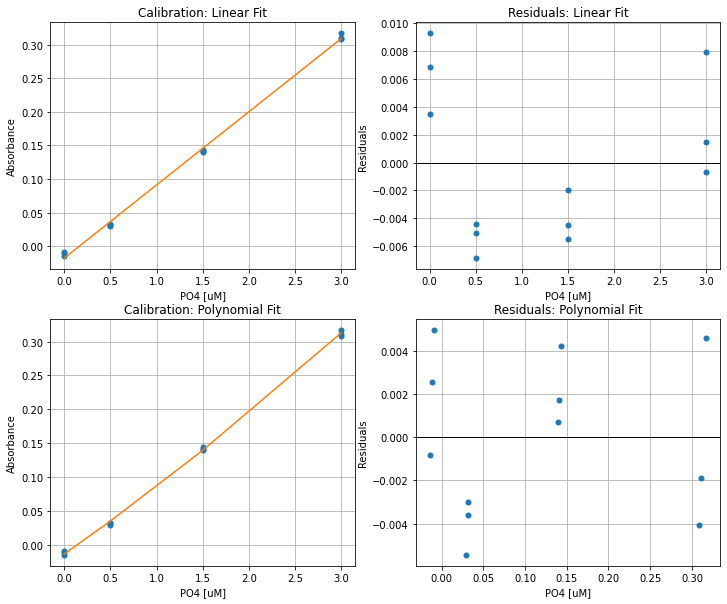

In [6]:
x = np.array([0, 0, 0, 0.5, 0.5, 0.5, 1.5, 1.5, 1.5, 3, 3, 3])

y = np.array([-0.011042, -0.014414, -0.008635, 0.032145, 0.029732, 0.031548, 0.140101, 0.143616, 0.141117, 0.317073, 0.308428, 0.31059])

pfi.calib_plots(x,y)

In [7]:
def calib_stats(x,y,alpha=0.5):
    
    from scipy import stats
    from tabulate import tabulate
    import numpy as np


    lin_results = stats.linregress(x,y)
    a2 = lin_results[0] #linear slope 
    intercept = lin_results [1] #intercept of linear model
    y_hat = (a2*x) + intercept

    
    poly_results = np.polyfit(x,y,deg=2)
    
    r_squared = lin_results.rvalue**2
    
    N=len(x)
    mean_x = np.mean(x)
    s_yx = np.sqrt(sum((y-y_hat)**2)/(N-2)) #random error in the y-direction

    s_m = s_yx / (np.sqrt(sum((x-mean_x)**2))) #standard deviation of the slope
    
    blanks = y[0:3] #assumes that first 3 datapoints in calibration are blanks in triplicate
    
    LOD = 1000 * ((3*np.std(blanks))/a2) #Limit of detection (nm)
    
    table = [['Slope', 'Intercept', 'R-squared', 'Standard Deviation of the Slope', 'Limit of Detection (nm)'], [a2, intercept, r_squared, s_m, LOD]]

    
    return print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))



In [8]:
x = np.array([0, 0, 0, 0.5, 0.5, 0.5, 1.5, 1.5, 1.5, 3, 3, 3])
y = np.array([-0.00926, -0.013907, -0.011078, 0.026786, 0.028002, 0.033345, 0.131922, 0.136163, 0.134338, 0.295594, 0.295848, 0.296449])

pfi.calib_stats(x,y)


╒══════════╤═════════════╤═════════════╤═══════════════════════════════════╤═══════════════════════════╕
│    Slope │   Intercept │   R-squared │   Standard Deviation of the Slope │   Limit of Detection (nm) │
╞══════════╪═════════════╪═════════════╪═══════════════════════════════════╪═══════════════════════════╡
│ 0.103563 │  -0.0174373 │    0.998273 │                        0.00136201 │                   55.3875 │
╘══════════╧═════════════╧═════════════╧═══════════════════════════════════╧═══════════════════════════╛


In [9]:
#using a Grubb's test to identify any outliers in my dataset

from outliers import smirnov_grubbs as grubbs
import numpy as np

y = np.array([-0.00926, -0.013907, 4, 0.026786, 0.028002, 0.033345, 0.131922, 0.136163, 0.134338, 0.295594, 0.295848, 0.296449])

calib1 = y[0:3]
calib2 = y[3:6]
calib3 = y[6:9]
calib4 = y[9:12]

def outlier_test(values):
    relstdev = 100 * (np.std(values)/np.mean(values))
    if (relstdev > 10):
        outlier = grubbs.max_test_outliers(values, alpha=.05) 
        return outlier
    
    else: print('No outlier')

outlier_test(calib2)

No outlier


#### *Applying functions to PO4 method optimization: How does increasing the sample:reagent ratio impact the analytical sensitivity?* ####

In [10]:
#Extract calibration slopes using linear regression based on indexes used for calibrations run using each sample:reagent ratio
x = [0,0,0,0.5,0.5,0.5,1.5,1.5,1.5,3,3,3]
three = pfi.slope_from_index(x, np.arange(1118,1130))
four = pfi.slope_from_index(x, np.arange(1097,1109))
five = pfi.slope_from_index(x, np.arange(1076,1088))
six = pfi.slope_from_index(x, np.arange(1054,1066))
seven = pfi.slope_from_index(x, np.arange(1139,1151))
eight = pfi.slope_from_index(x, np.arange(964,976))
y = np.array([three, four, five, six, seven, eight])

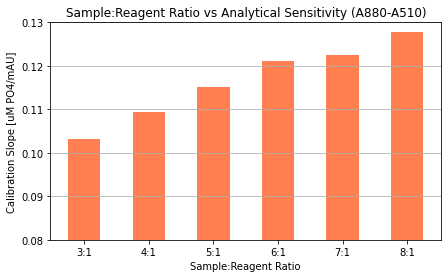

In [11]:
#Plotting results
x = ['3:1','4:1','5:1','6:1','7:1','8:1']
plt.figure(figsize=[7,4])
plt.bar(x,y,width=0.5,color='coral')
plt.ylim(0.08,0.13)
plt.xlabel('Sample:Reagent Ratio')
plt.ylabel('Calibration Slope [uM PO4/mAU]')
plt.title('Sample:Reagent Ratio vs Analytical Sensitivity (A880-A510)')
plt.grid(axis='y')

#include error bars (95% CI)

Increasing the volume of sample that is mixed with my reagents tends to increase the sensitivity of the method, indicated by an increase in the calibration slope. 

In [12]:
#Are any of these calibration slopes significantly different from one another?

In [17]:
import pingouin as pg

y = np.array([three,four, five, six, seven, eight])

columns = ['3:1','4:1','5:1','6:1','7:1','8:1']

data = [['3:1',y[0]],['4:1',y[1]],['5:1',y[2]],['6:1',y[3]],['7:1',y[4]],['8:1',y[5]]]


df = pd.DataFrame(data,columns = ['ratios','slopes'])
df

#pg.anova(data=df,dv='slopes',between ='ratios')
#pg.pairwise_tukey(data=df,dv=df['slopes'],between =df['ratios'])


,ratios,slopes
0,3:1,0.103181
1,4:1,0.109276
2,5:1,0.115240
3,6:1,0.121013
4,7:1,0.122415
5,8:1,0.127724


#### *Conclusion and Next Steps* ####

Next Steps for PO4 method development using PFI:
-Stability of reagents over time (~1 month), using statistical analyses to understand changes in sensitivity, accuracy, precision, etc from each reagent component over time 
-MLML Shore station deployment to obtain near-real time PO4 (and eventually Si) data (time-series analysis, spectral analysis)

In [14]:
##Items/functions yet to be included into final notebook:

##FUNCTIONS:
# Being able to upload data from any range of indexes
# Concentration from calibration and absorbance values using 2nd deg polynomial


# Extracting slopes and plotting: what is the effect of Molybdate and H+ on the sensitivity of PO4 determination using pFI?
# Plotting a PO4 profile from Monterey Bay using indexes

#Add references